# Data Engineering Exercise

**Author:** Audrey McMillion

## 1. Architecture Overview

I am admittedly not an expert in AWS architecture, but I found a great explanation of a simple pipeline for this task [here](https://www.reddit.com/r/dataengineering/comments/spvmin/simple_solution_for_data_pipeline_to_redshift/). It involves
1. Extracting from the Open Library API using a Lambda function.
2. Storing the extracted (unstructured) data in an S3 bucket.
3. Transforming the data into a relational format using another Lambda function.
4. Storing in a relational database like AWS Redshift.

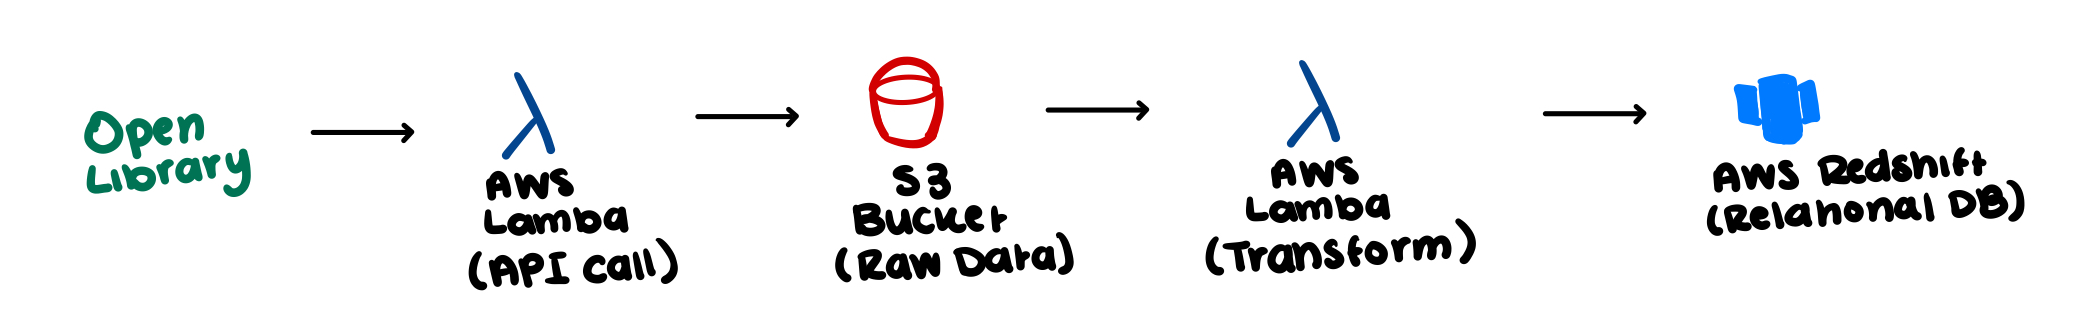

In [71]:
from IPython.display import Image
Image(filename='aws_pipeline.jpeg') 

## 2. Python Script

### Write a Python script to pull data from the API.

First, we pull all records for books related to "baking" using the ``ExtractLibrary`` class given below.

In [19]:
import requests
import sqlite3
import pandas as pd
import time

class ExtractLibrary:
    def __init__(self, db_name: str):
        self.conn = sqlite3.connect(db_name)

    # function to create authors table 
    def create_author_table(self) -> None:
        self.conn.execute("""CREATE TABLE IF NOT EXISTS authors (
                             author_id TEXT PRIMARY KEY UNIQUE,
                             name      TEXT)""")

    # function to create books table
    def create_book_table(self) -> None:
        self.conn.execute("""CREATE TABLE IF NOT EXISTS books (
                 book_id TEXT,
                 title TEXT,
                 author_id TEXT,
                 first_publish_year INTEGER,
                 unique (book_id, title, author_id, first_publish_year))""")

    # function to drop authors table
    def drop_author_table(self) -> None:
        self.conn.execute("""DROP TABLE authors""")

    # function to drop books table
    def drop_book_table(self) -> None:
        self.conn.execute("""DROP TABLE books""")
        

    # NOTE: This code is modified from https://www.sqlitetutorial.net/sqlite-python/insert/
    def add_author(self, author_row):
        # insert table statement
        sql = ''' INSERT OR IGNORE INTO authors (author_id, name)
                  VALUES(?,?) '''
        
        # create  a cursor
        cur = self.conn.cursor()
    
        # execute the INSERT statement
        cur.execute(sql, author_row)
    
        # commit the changes
        self.conn.commit()
    
        # get the id of the last inserted row
        return cur.lastrowid

    # NOTE: This code is modified from https://www.sqlitetutorial.net/sqlite-python/insert/
    def add_book(self, book_row):
         # insert table statement
        sql = ''' INSERT OR IGNORE INTO books (book_id, title, author_id, first_publish_year)
                  VALUES(?,?,?,?) '''
        
        # Create  a cursor
        cur = self.conn.cursor()
    
        # execute the INSERT statement
        cur.execute(sql, book_row)
    
        # commit the changes
        self.conn.commit()
    
        # get the id of the last inserted row
        return cur.lastrowid

    # function for pulling book records related to a given subject
    def pull_subject_records(self, subject: str) -> dict:
        url = "https://openlibrary.org/subjects/{0}.json".format(subject)

        # get request & loop parameters
        limit = 100  # max per request
        offset = 0
        all_works = []
        work_count = -1

        while True:
            params = {"limit": limit, "offset": offset}
        
            response = requests.get(url, params=params)
        
            # check that the pull was successful
            if response.status_code == 200:
                response_dict = response.json()
            else:
                exception_str = "Error " + str(response.status_code) + " returned"
                raise Exception(exception_str)

            # get current works
            current_works = response_dict['works']
            all_works += current_works

            # get work count
            if offset == 0:
                work_count = response_dict['work_count']

            # increase offset
            offset += limit

            # less values were returned than needed
            if len(current_works) < 100:
                # print final progress update
                print(len(all_works), "/", work_count, "works processed.") 
                break

            # print progress update
            print(offset, "/", work_count, "works processed.") 

            # sleep for some time before making next API call
            time.sleep(0.25)

        assert(work_count == len(all_works))

        return all_works

    # function for storing the book records in the authors and books SQLite tables
    def insert_data(self, subject: str, drop_tables = False, create_tables = False) -> None:
        if drop_tables:
            self.drop_author_table()
            self.drop_book_table()
            
        if create_tables:
            self.create_author_table()
            self.create_book_table()

        # pull values from API
        response_works = self.pull_subject_records(subject)

        # loop through each of the works in the response
        for val in response_works:
            title = val['title']
            book_id = val['key'].replace("/works/", "")
            first_publish_year = val['first_publish_year']
            authors = val['authors']

            # loop through each of the authors
            for author_details in authors:
                author_id = author_details['key'].replace("/authors/", "")
                author_name = author_details['name']

                # create author and book row
                author_row = (author_id, author_name)
                book_row = (book_id, title, author_id, first_publish_year)

                # insert into sqlite databases (authors, books)
                self.add_author(author_row)
                self.add_book(book_row)  

In [20]:
# set up database
e_library = ExtractLibrary('library.db')

In [21]:
# insert all books with "baking" subject into database
e_library.insert_data(subject = "baking", drop_tables = True, create_tables=True)

100 / 3807 works processed.
200 / 3807 works processed.
300 / 3807 works processed.
400 / 3807 works processed.
500 / 3807 works processed.
600 / 3807 works processed.
700 / 3807 works processed.
800 / 3807 works processed.
900 / 3807 works processed.
1000 / 3807 works processed.
1100 / 3807 works processed.
1200 / 3807 works processed.
1300 / 3807 works processed.
1400 / 3807 works processed.
1500 / 3807 works processed.
1600 / 3807 works processed.
1700 / 3807 works processed.
1800 / 3807 works processed.
1900 / 3807 works processed.
2000 / 3807 works processed.
2100 / 3807 works processed.
2200 / 3807 works processed.
2300 / 3807 works processed.
2400 / 3807 works processed.
2500 / 3807 works processed.
2600 / 3807 works processed.
2700 / 3807 works processed.
2800 / 3807 works processed.
2900 / 3807 works processed.
3000 / 3807 works processed.
3100 / 3807 works processed.
3200 / 3807 works processed.
3300 / 3807 works processed.
3400 / 3807 works processed.
3500 / 3807 works proce

## 3. Sample Data Output

### Provide CSV outputs for 'Authors' and 'Books'.

Extract all records from ``authors`` table and save as CSV.

In [22]:
authors = pd.read_sql("SELECT * FROM authors", e_library.conn)
authors.to_csv("authors.csv", index=False)

In [23]:
# view data
authors.head()

,author_id,name
0,OL366346A,Maurice Sendak
1,OL216222A,Wayne Gisslen
2,OL3412520A,W Gisslen
3,OL7739076A,Wayne Gisslen
4,OL224488A,Sarah R. Labensky


Extract all records from ``books`` table and save as CSV.

In [24]:
books = pd.read_sql("SELECT * FROM books", e_library.conn)
books.to_csv("books.csv", index=False)

In [25]:
# view data
books.head()

,book_id,title,author_id,first_publish_year
0,OL2568868W,In the Night Kitchen,OL366346A,1889.0
1,OL1802168W,Panaderia y Reposteria para profesionales/Prof...,OL216222A,1985.0
2,OL1802168W,Panaderia y Reposteria para profesionales/Prof...,OL3412520A,1985.0
3,OL1802168W,Panaderia y Reposteria para profesionales/Prof...,OL7739076A,1985.0
4,OL1874828W,On baking,OL224488A,2004.0


### Include a simple 'Authors and Books' relation (no need for a full bridge table).

**Note**: Unsure if this is asking for a full join, but will do so just in case. Basically, you just join the two tables on the ``author_id``.

In [26]:
author_and_books = pd.read_sql("""
    SELECT b.*, a.name AS author_name
    FROM books b
    LEFT JOIN authors a
    ON b.author_id = a.author_id
""", e_library.conn)
author_and_books.to_csv("author_and_books.csv", index=False)

In [27]:
author_and_books.head()

,book_id,title,author_id,first_publish_year,author_name
0,OL2568868W,In the Night Kitchen,OL366346A,1889.0,Maurice Sendak
1,OL1802168W,Panaderia y Reposteria para profesionales/Prof...,OL216222A,1985.0,Wayne Gisslen
2,OL1802168W,Panaderia y Reposteria para profesionales/Prof...,OL3412520A,1985.0,W Gisslen
3,OL1802168W,Panaderia y Reposteria para profesionales/Prof...,OL7739076A,1985.0,Wayne Gisslen
4,OL1874828W,On baking,OL224488A,2004.0,Sarah R. Labensky


## 4. Data Processing

### Write a SQL query (or Python equivalent) to aggregate...

Note that sometimes there can to be difference ``author_id``s for the same author provided by OpenLibrary, sometimes due to slight spelling differences (see ``author_and_books.head()`` shown above). Given the time constraints, I will not be trying to mitigate this particular issue in the below queries.

#### (a) The number of books written each year by an author

Here, I design a SQL query that counts the number of books published per year by a given author.

In [73]:
author_books_per_year = pd.read_sql("""
    WITH author_and_books AS (
        SELECT b.author_id, b.first_publish_year, a.name AS author_name
        FROM books b
        LEFT JOIN authors a
        ON b.author_id = a.author_id
    )

    SELECT * 
    FROM (
        SELECT author_id, author_name, first_publish_year, count(*) AS num_books
        FROM author_and_books
        GROUP BY 1, 2, 3
    )
    ORDER BY num_books DESC
""", e_library.conn)

In [74]:
author_books_per_year

,author_id,author_name,first_publish_year,num_books
0,OL7215935A,United States. Department of Agriculture. Radi...,1939.0,13
1,OL7215935A,United States. Department of Agriculture. Radi...,1941.0,13
2,OL7215935A,United States. Department of Agriculture. Radi...,1935.0,12
3,OL7215935A,United States. Department of Agriculture. Radi...,1940.0,12
4,OL7215935A,United States. Department of Agriculture. Radi...,1928.0,11
...,...,...,...,...
3492,OL9943534A,Esperanza Martínez Pérez,2002.0,1
3493,OL9956601A,Miriam Pascal,2015.0,1
3494,OL9968863A,Robin Hood Flour Mills Limited,1941.0,1
3495,OL9968890A,St. Lawrence Flour Mills Co,NaN,1


#### (b) The average number of books written by an author per year.

In [75]:
avg_books_per_author = pd.read_sql("""
    WITH author_and_books AS (
        SELECT b.author_id, b.first_publish_year, a.name AS author_name
        FROM books b
        LEFT JOIN authors a
        ON b.author_id = a.author_id
    ),

    num_books_per_year AS (
        SELECT author_id, author_name, first_publish_year, count(*) AS num_books
        FROM author_and_books
        GROUP BY 1, 2, 3
    )

    SELECT author_id, author_name, avg_books_per_year, num_years
    FROM (
        SELECT author_id, author_name, AVG( num_books * 1.0 ) AS avg_books_per_year, COUNT(*) AS num_years
        FROM num_books_per_year
        GROUP BY 1, 2
    )
    ORDER BY num_years DESC
""", e_library.conn)

In [76]:
avg_books_per_author

,author_id,author_name,avg_books_per_year,num_years
0,OL27838A,Betty Crocker,1.350000,20
1,OL7215935A,United States. Department of Agriculture. Radi...,7.500000,20
2,OL5013405A,Pillsbury Company,1.187500,16
3,OL395598A,Linda Collister,2.357143,14
4,OL578185A,Joseph Amendola,1.000000,9
...,...,...,...,...
2722,OL9943534A,Esperanza Martínez Pérez,1.000000,1
2723,OL9956601A,Miriam Pascal,1.000000,1
2724,OL9968863A,Robin Hood Flour Mills Limited,1.000000,1
2725,OL9968890A,St. Lawrence Flour Mills Co,1.000000,1


### Discuss how you would optimize this for a larger dataset.

For a larger dataset, we could make ``first_publish_year`` a partition key in the ``books`` table. This could potentially speed up aggregate functions by year.

## 5. Presentation

I am omitting the presentation portion due to time constraints, but I would be happy to discuss any portion of this code.